# CSE 6367 Programming Assignment 2 (P2)

## Spring 2023

## Due: 11:59pm Central Time, Wednesday, April 5, 2023

### Task 1 (50 points) 

Implement Hough transform from scratch to detect circles in the image. Refer to this wiki page for pseudocode(https://en.wikipedia.org/wiki/Circle_Hough_Transform). Superimpose detected circles on the original image.

Note: You shouldn't use cv2.HoughCircles() to detect the circles.

![circles-2.jpeg](attachment:circles-2.jpeg)

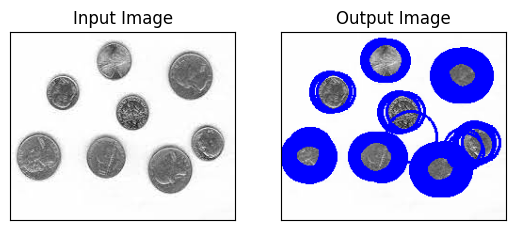

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_path = '/content/Images/circles.jpeg'

# Load the input image
def readImage(img_path):
  load_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  return load_img

def getRadius(radii_range):
  mn_radii, mx_radii = radii_range
  return mn_radii, mx_radii

def drawCircle(load_img):
  final_img = cv2.cvtColor(load_img, cv2.COLOR_GRAY2BGR)
  for ccl in circles:
      x, y, r = ccl
      cv2.circle(final_img, (x, y), r, (0, 0, 255), 2)
  return final_img

def show_result(load_img, op_img):
  # Display the input image and the output image
  plt.subplot(121),plt.imshow(load_img,cmap = 'gray')
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(op_img)
  plt.title('Output Image'), plt.xticks([]), plt.yticks([])
  plt.show()

def hough_circles(load_img, radius_range):

    # set range of radii 
    mn_radii, mx_radii = getRadius(radius_range)

    # set the Hough space
    h, w = load_img.shape
    acc = np.zeros((h, w, mx_radii - mn_radii + 1), dtype=np.uint32)

    # set edge detection th
    th = 100

    # Used Canny edge detector to detect det_edge
    det_edge = cv2.Canny(load_img, th, th * 2)

    # Finding the possible radii and inserted in the Hough space
    for r in range(mn_radii, mx_radii + 1):
        for x in range(w):
            for y in range(h):
                if det_edge[y, x] > 0:
                    # Calculating the center of the ccl 
                    a = x
                    b = y
                    for t in range(360):
                        theta = t * np.pi / 180
                        x0 = int(round(a + r * np.cos(theta)))
                        y0 = int(round(b + r * np.sin(theta)))
                        if x0 >= 0 and x0 < w and y0 >= 0 and y0 < h:
                            acc[y0, x0, r - mn_radii] += 1

    # Finding Peaks in the Hough space
    peaks = []
    for r in range(mx_radii - mn_radii + 1):
        for x in range(w):
            for y in range(h):
                if acc[y, x, r] >= th:
                    peaks.append((x, y, r + mn_radii))

    # Return the detected circles
    return peaks


load_img = readImage(img_path)

# Define the range of radii to search for
radius_range = (20, 80)

# Detect circles using the Hough Transform
circles = hough_circles(load_img, radius_range)

# Draw the detected circles on the input image
op_img = drawCircle(load_img)

show_result(load_img, op_img)


### Task 2 (50 points)

Implement Harris corner detector from scratch. The steps are mentioned in Slide 46-47 on your lecture slide "5-Harris-corner-detector.pdf". Mark detected corners on original image. 

Note: You shouldn't use cv2.cornerHarris() to detect the corners.

![checkerboard-2.png](attachment:checkerboard-2.png)

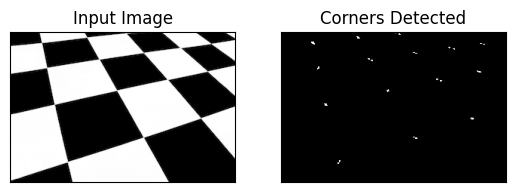

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

path2 = "/content/Images/checkerboard.png"

# Calculate image derivatives
def img_derivatives(img):
    deltaX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    deltaY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    return deltaX, deltaY

# Calculate products of derivatives
def prodDerivatives(deltaX, deltaY):
  double_deltaX = deltaX * deltaX
  deltaX_deltaY = deltaX * deltaY
  double_deltaY = deltaY * deltaY
  return double_deltaX, deltaX_deltaY, double_deltaY

# Calculate the sum of products of derivatives over the window
def filterApply(double_deltaX, deltaX_deltaY, double_deltaY, window_size):
  double_sumX = cv2.boxFilter(double_deltaX, cv2.CV_64F, (window_size, window_size))
  sumX_sumY = cv2.boxFilter(deltaX_deltaY, cv2.CV_64F, (window_size, window_size))
  double_sumY = cv2.boxFilter(double_deltaY, cv2.CV_64F, (window_size, window_size))
  return double_sumX, sumX_sumY, double_sumY 

# Calculate the determinant and trace of the matrix M
def det_and_trace(double_sumX, double_sumY, sumX_sumY):
  determinant = double_sumX * double_sumY - sumX_sumY * sumX_sumY
  trace_val = double_sumX + double_sumY
  return determinant, trace_val

# Calculate the corner response function
def calc_corner(determinant, k, trace_val):
  return determinant - k * (trace_val ** 2)

# Normalize the corner response function
def calc_norm(all_corner):
  return cv2.normalize(all_corner, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Threshold the corner response function to obtain the corners
def findCorner(corner_normalization,threshold, window_size ):
    corners = np.zeros_like(img)
    corners[corner_normalization > threshold] = 255

    # Perform local maxima suppression
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size))
    corners = cv2.dilate(corners, kernel)
    corners[corners != 255] = 0
    corners = cv2.erode(corners, kernel)

    # Return the binary image with corners detected
    return corners

def getPlot(img, corners):
  # Display the input image and the output image with corners detected
  plt.subplot(121),plt.imshow(img,cmap = 'gray')
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(corners,cmap = 'gray')
  plt.title('Corners Detected'), plt.xticks([]), plt.yticks([])
  plt.show()


def harris_corner_detector(img, k=0.04, threshold=0.5, window_size=3):
    deltaX, deltaY = img_derivatives(img)
    
    double_deltaX, deltaX_deltaY, double_deltaY = prodDerivatives(deltaX, deltaY)

    double_sumX, sumX_sumY, double_sumY = filterApply(double_deltaX, deltaX_deltaY, double_deltaY, window_size)
    
    determinant, trace_val = det_and_trace(double_sumX, double_sumY, sumX_sumY)
    
    all_corner = calc_corner(determinant, k, trace_val)
    
    corner_normalization = calc_norm(all_corner)

    return findCorner(corner_normalization,threshold, window_size)

# Load the input image
img = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

# Detect corners using the Harris Corner Detector
corners = harris_corner_detector(img)

getPlot(img, corners)

## Submission Guidelines:

    Submit through Canvas your source code in a single .ipynb file. The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
    Import all the images from the ./Images directory. Your TA will use the same directory name to grade your submission.
    You don't need to attach the image file with your submission.
